In [ ]:
import numpy as np
import tensorflow as tf
import os # Directory navigation
import random
import wave # Read wav file
import librosa # More audio processing
import seaborn as sns
import pathlib
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the path to your main dataset directory
LOADING_PATH = 'data/mini_speech_commands'
DATASET_PATH = 'data/mini_speech_commands_extracted/mini_speech_commands/'
# Set seed
seed = 36
tf.random.set_seed(seed)
np.random.seed(seed)

# 1. Dataset Preparation:
Use the Google Speech Commands Dataset and add noise variants. Optionally, for bonus points, extend the dataset to support additional languages by integrating public datasets (e.g., French, Spanish).


In [2]:
#Download and extract the `mini_speech_commands.zip` file containing the smaller Speech Commands datasets with `tf.keras.utils.get_file`:
data_dir = pathlib.Path(LOADING_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

The dataset's audio clips are stored in eight folders corresponding to each speech command: `no`, `yes`, `down`, `go`, `left`, `up`, `right`, and `stop`:

In [3]:
commands = np.array(tf.io.gfile.listdir(str(DATASET_PATH)))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store')]
print('Commands:', commands)

Commands: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


Each command has ~2375 examples.

From README:
The data was captured in a
variety of formats, for example Ogg Vorbis encoding for the web app, and then
converted to a 16-bit little-endian PCM-encoded WAVE file at a 16000 sample
rate. The audio was then trimmed to a one second length to align most
utterances, using the
extract_loudest_section
tool. The audio files were then screened for silence or incorrect words, and
arranged into folders by label.

Divided into directories this way, you can easily load the data using `keras.utils.audio_dataset_from_directory`. 

The audio clips are 1 second or less at 16kHz. The `output_sequence_length=16000` pads the short ones to exactly 1 second (and would trim longer ones) so that they can be easily batched.

In [4]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=DATASET_PATH,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both')

print(np.array(train_ds.class_names))
print()
#print("label names:", label_names)

Found 8000 files belonging to 8 classes.
Using 6400 files for training.
Using 1600 files for validation.
['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']



Inspect the dataset

In [5]:
train_ds.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

The audio is mono/single channel - drop the extra axis
shape=(None, 16000, None)

In [6]:
# Define function to drop extra axis
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

# Drop extra axises
train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

# Re-examine shape of dataset
for example_audio, example_labels in train_ds.take(1):  
  print(example_audio.shape)
  print(example_labels.shape)

(64, 16000)
(64,)


Batch of 64 audio files with 1600hz sample rates?


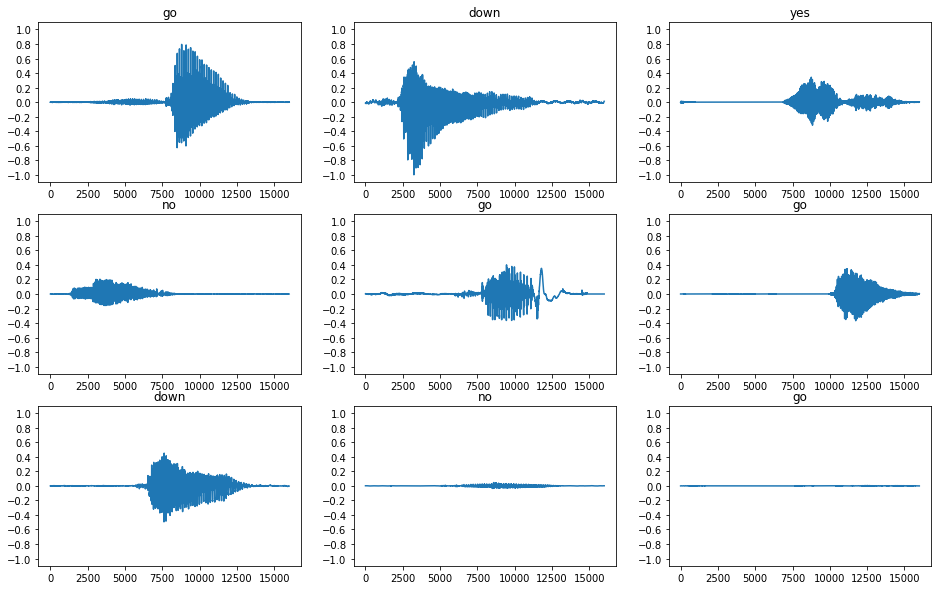

In [7]:
commands[[1,1,3,0]]

plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(commands[example_labels[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])

## *add test set*
## *remove plots??*

# Add Noise
*use SNR calculation to add noise??*
*leave for now. come back later to randomly add background noise*

In [18]:
# Define the function to add noise
def add_random_noise(audio, label, noise_level=0.0015):
    """
    Add random noise to an audio signal.
    :param audio: TensorFlow tensor representing the audio signal
    :param label: Corresponding label for the audio
    :param noise_level: Standard deviation of the noise
    :return: Augmented audio with noise and the label
    """
    noise = tf.random.normal(shape=tf.shape(audio), mean=0.0, stddev=noise_level, dtype=audio.dtype)
    augmented_audio = audio + noise
    return augmented_audio, label

# Apply the noise augmentation
noise_level = 0.0015  # You can adjust this based on desired noise intensity
augmented_trainset = train_ds.map(lambda x, y: add_random_noise(x, y, noise_level))
augmented_valset = val_ds.map(lambda x, y: add_random_noise(x, y, noise_level))


Audio shape: (64, 16000)
Label: tf.Tensor(
[6 3 2 1 6 0 5 3 4 5 0 3 1 0 1 6 5 7 7 5 0 0 7 4 0 7 0 1 7 3 1 5 1 6 7 2 0
 3 6 2 5 6 4 0 1 0 4 2 1 5 1 0 7 3 1 2 6 0 7 5 7 5 5 2], shape=(64,), dtype=int32)


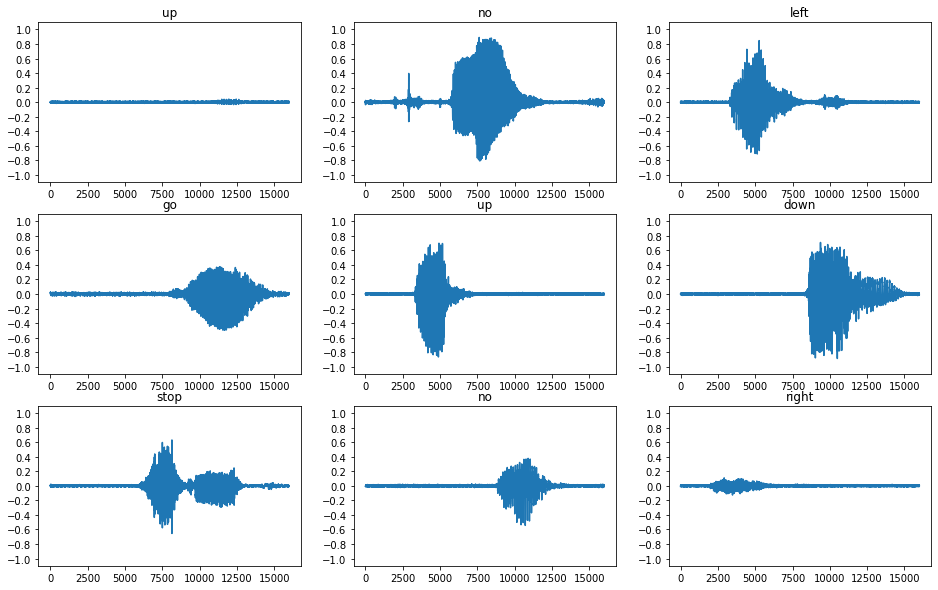

In [16]:
# Preview an example
for audio, label in augmented_trainset.take(1):
    print("Audio shape:", audio.shape)
    print("Label:", label)

commands[[1,1,3,0]]

plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = audio[i]
  plt.plot(audio_signal)
  plt.title(commands[label[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])

## Explore augmented data

In [ ]:
for i in range(3):
  label = commands[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: go
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: down
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: yes
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Augmented

In [ ]:
# Preview an example
for audio, xlabel in augmented_trainset.take(1):
    print("Audio shape:", audio.shape)
    print("Label:", label)

for i in range(3):
  label = commands[xlabel[i]]
  waveform = audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Audio shape: (64, 16000)
Label: no
Label: no
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: yes
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: go
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


You can hear the background noise!!

# Extract Features

## Spectograms

### Convert waveforms to spectrograms

The waveforms in the dataset are represented in the time domain. Next, you'll transform the waveforms from the time-domain signals into the time-frequency-domain signals by computing the [short-time Fourier transform (STFT)](https://en.wikipedia.org/wiki/Short-time_Fourier_transform) to convert the waveforms to as [spectrograms](https://en.wikipedia.org/wiki/Spectrogram), which show frequency changes over time and can be represented as 2D images. You will feed the spectrogram images into your neural network to train the model.

A Fourier transform (`tf.signal.fft`) converts a signal to its component frequencies, but loses all time information. In comparison, STFT (`tf.signal.stft`) splits the signal into windows of time and runs a Fourier transform on each window, preserving some time information, and returning a 2D tensor that you can run standard convolutions on.

Create a utility function for converting waveforms to spectrograms:

- The waveforms need to be of the same length, so that when you convert them to spectrograms, the results have similar dimensions. This can be done by simply zero-padding the audio clips that are shorter than one second (using `tf.zeros`).
- When calling `tf.signal.stft`, choose the `frame_length` and `frame_step` parameters such that the generated spectrogram "image" is almost square. For more information on the STFT parameters choice, refer to [this Coursera video](https://www.coursera.org/lecture/audio-signal-processing/stft-2-tjEQe) on audio signal processing and STFT.
- The STFT produces an array of complex numbers representing magnitude and phase. However, in this tutorial you'll only use the magnitude, which you can derive by applying `tf.abs` on the output of `tf.signal.stft`.

In [10]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram